In [24]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from models import FCActorCriticNetwork, FCReturnModel
from trainers import PPOTrainer, AIRLTrainer
from training import train_with_ppo
from utils import rollout, TrajectoryData

sns.set()

%matplotlib inline

In [2]:
DEVICE = 'cuda'
env = gym.make('CartPole-v0')

## Expert Model Training

In [3]:
expert_model = FCActorCriticNetwork(env.observation_space.shape[0], env.action_space.n)
expert_model = expert_model.to(DEVICE)

# Define training params
expert_params = {
  'n_episodes': 200,
  'print_freq': 20
}

expert_trainer = PPOTrainer(
    expert_model,
    policy_lr = 3e-4,
    value_lr = 1e-3,
    target_kl_div = 0.02,
    max_policy_train_iters = 40,
    value_train_iters = 40)

rewards = train_with_ppo(expert_model, expert_trainer, env, expert_params)

Episode 20 | Avg Reward 19.6
Episode 40 | Avg Reward 12.7
Episode 60 | Avg Reward 49.4
Episode 80 | Avg Reward 141.3
Episode 100 | Avg Reward 146.2
Episode 120 | Avg Reward 156.4
Episode 140 | Avg Reward 171.5
Episode 160 | Avg Reward 198.8
Episode 180 | Avg Reward 200.0
Episode 200 | Avg Reward 174.2


## Data Gathering

In [4]:
n_expert_samples = 50
expert_rollouts = []
print('Generating expert samples...')
for _ in tqdm(range(n_expert_samples)):
  expert_rollouts.append(rollout(expert_model, env, 200)[0])
  
ep_rewards = [sum(r.rewards) for r in expert_rollouts]
avg_reward = np.mean(ep_rewards)
reward_std = np.std(ep_rewards)
  
print('Avg reward:', avg_reward)
print('Reward std:', reward_std)

Generating expert samples...


  0%|          | 0/50 [00:00<?, ?it/s]

Avg reward: 136.64
Reward std: 25.31304801875902


## AIRL Training

In [5]:
def reward_modifier_hook(rollout_data, return_model, device, reward_list=None):
  obs = torch.tensor(
    rollout_data.obs[:-1],
    dtype=torch.float32, device=device)
  next_obs = torch.tensor(
    rollout_data.obs[1:],
    dtype=torch.float32, device=device)
  act_probs = torch.tensor(
    np.exp(rollout_data.act_log_probs),
    dtype=torch.float32, device=device).view(-1, 1)
  
  rewards = return_model.discrim(obs, next_obs, act_probs)
  rewards = rewards.squeeze().detach().cpu().numpy()
  
  if reward_list is not None:
    reward_list.append(sum(rewards))
  
  new_rollout_data = TrajectoryData(
    rollout_data[0],
    rollout_data[1],
    rewards,
    rollout_data[3],
    rollout_data[4])
  
  return new_rollout_data

In [6]:
def format_discrim_train_data(expert_rollouts, learner_rollouts, device):
  discrim_train_data = [[], [], [], []]
  for rollout_data in (expert_rollouts + learner_rollouts):
    discrim_train_data[0].extend(rollout_data.obs[:-1])
    discrim_train_data[1].extend(rollout_data.obs[1:])
    discrim_train_data[2].extend(np.exp(rollout_data.act_log_probs))
    
  for rollout_data in expert_rollouts:
    discrim_train_data[3].extend(np.ones(len(rollout_data.obs) - 1))
    
  for rollout_data in learner_rollouts:
    discrim_train_data[3].extend(np.zeros(len(rollout_data.obs) - 1))
    
  discrim_train_data = [torch.tensor(x, dtype=torch.float32, device=device) \
                        for x in discrim_train_data]
  discrim_train_data[2] = discrim_train_data[2].view(-1, 1)
  discrim_train_data[3] = discrim_train_data[3].view(-1, 1)
  
  return discrim_train_data

In [39]:
learner_model = FCActorCriticNetwork(env.observation_space.shape[0], env.action_space.n)
learner_model = learner_model.to(DEVICE)
learner_trainer = PPOTrainer(
    learner_model,
    policy_lr = 3e-4,
    value_lr = 1e-3,
    target_kl_div = 0.02,
    max_policy_train_iters = 40,
    value_train_iters = 40)
# Define training params
learner_params = {
  'n_episodes': 5
}

return_model = FCReturnModel(env.observation_space.shape[0])
return_model = return_model.to(DEVICE)
airl_trainer = AIRLTrainer(
  return_model,
  reward_lr=1e-4,
  discrim_lr=1e-4)

In [40]:
n_epochs = 1000
rollouts_per_epoch = 5
print_freq = 10

In [41]:
discrim_losses = []
env_real_rewards = []
env_irl_rewards = []

for epoch in range(n_epochs):
  # Simulate learner rollouts
  learner_rollouts = [rollout(learner_model, env, 200)[0] for _ in range(rollouts_per_epoch)]
  expert_rollout_idxs = np.random.choice(list(range(len(expert_rollouts))), size=rollouts_per_epoch, replace=False)
  expert_rollout_samples = [expert_rollouts[i] for i in expert_rollout_idxs]
  discrim_train_data = format_discrim_train_data(expert_rollout_samples, learner_rollouts, DEVICE)
  
  discrim_loss = airl_trainer.train_discrim(*discrim_train_data)
  discrim_losses.append(discrim_loss)
  
  data_hook = lambda data: reward_modifier_hook(data, return_model, DEVICE, env_irl_rewards)
  real_rewards = train_with_ppo(learner_model, learner_trainer, env, learner_params, data_hook)
  env_real_rewards.extend(real_rewards)
  
  if epoch != 0 and epoch % print_freq == 0:
    print('Epoch #{} | Discrim losses: {:.2f} | Real rewards: {:.2f} | IRL rewards: {:.2f}'.format(
      epoch,
      np.mean(discrim_losses[-print_freq:]),
      np.mean(env_real_rewards[-print_freq:]),
      np.mean(env_irl_rewards[-print_freq:])))

Epoch #10 | Discrim losses: 0.61 | Real rewards: 78.70 | IRL rewards: 46.40
Epoch #20 | Discrim losses: 0.70 | Real rewards: 106.20 | IRL rewards: 58.86
Epoch #30 | Discrim losses: 0.66 | Real rewards: 112.50 | IRL rewards: 62.38
Epoch #40 | Discrim losses: 0.67 | Real rewards: 200.00 | IRL rewards: 103.82
Epoch #50 | Discrim losses: 0.65 | Real rewards: 200.00 | IRL rewards: 99.97
Epoch #60 | Discrim losses: 0.63 | Real rewards: 200.00 | IRL rewards: 97.79
Epoch #70 | Discrim losses: 0.62 | Real rewards: 200.00 | IRL rewards: 96.13
Epoch #80 | Discrim losses: 0.61 | Real rewards: 200.00 | IRL rewards: 94.58
Epoch #90 | Discrim losses: 0.61 | Real rewards: 200.00 | IRL rewards: 92.71
Epoch #100 | Discrim losses: 0.60 | Real rewards: 199.50 | IRL rewards: 90.33
Epoch #110 | Discrim losses: 0.60 | Real rewards: 200.00 | IRL rewards: 91.09
Epoch #120 | Discrim losses: 0.61 | Real rewards: 200.00 | IRL rewards: 89.80
Epoch #130 | Discrim losses: 0.60 | Real rewards: 196.10 | IRL rewards: 8

KeyboardInterrupt: 

C:\Users\ninja\.conda\envs\ml-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

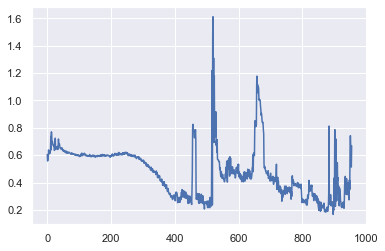

In [42]:
sns.lineplot(range(len(discrim_losses)), discrim_losses)

C:\Users\ninja\.conda\envs\ml-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

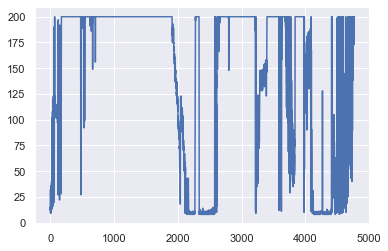

In [43]:
sns.lineplot(range(len(env_real_rewards)), env_real_rewards)

C:\Users\ninja\.conda\envs\ml-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

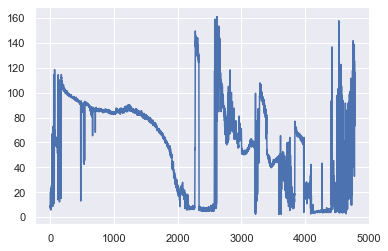

In [44]:
sns.lineplot(range(len(env_irl_rewards)), env_irl_rewards)